In [1]:
from __future__ import absolute_import, division, print_function
import os
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.VERSION)
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

print("TensorFlow Version:{}".format(tf.VERSION))
print("Eager excution: {}".format(tf.executing_eagerly()))

1.7.0
Instructions for updating:
Use the retry module or similar alternatives.
TensorFlow Version:1.7.0
Eager excution: True


TensorFlow Version:1.7.0
Eager excution: False


In [3]:
train_dataset_url = 'http://download.tensorflow.org/data/iris_training.csv'
train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                          origin=train_dataset_url)
print("Local copy of the dataset file:{}".format(train_dataset_fp))

Local copy of the dataset file:C:\Users\WEI\.keras\datasets\iris_training.csv


In [11]:
def parse_csv(line):
    
    example_defaults = [[0.],[0.],[0.],[0.],[0.]]
    parsed_line = tf.decode_csv(line,example_defaults)
    features = tf.reshape(parsed_line[:-1], shape=(4,))
    label = tf.reshape(parsed_line[-1], shape=())
    
    return features, label

train_dataset = tf.data.TextLineDataset(train_dataset_fp)
train_dataset = train_dataset.skip(1)             # skip the first header row
train_dataset = train_dataset.map(parse_csv)      # parse each row
train_dataset = train_dataset.shuffle(buffer_size=1000)  # randomize
train_dataset = train_dataset.batch(32)

# View a single example entry from a batch
features, label = tfe.Iterator(train_dataset).next()
print("example features:", features[0])
print("example label:", label[0])


example features: tf.Tensor([7.2 3.  5.8 1.6], shape=(4,), dtype=float32)
example label: tf.Tensor(2.0, shape=(), dtype=float32)


In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(4,)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3)
])

def loss(model, x, y):
    y_ = model(x)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

def grad(model, inputs, targets):
    with tfe.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, model.variables)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

## Note: Rerunning this cell uses the same model variables

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()

  # Training loop - using batches of 32
    for x, y in tfe.Iterator(train_dataset):
    # Optimize the model
        grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.variables),
                              global_step=tf.train.get_or_create_global_step())

    # Track progress
        epoch_loss_avg(loss(model, x, y))  # add current batch loss
    # compare predicted label to actual label
        epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

  # end epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

InvalidArgumentError: Value for attr 'Tlabels' of float is not in the list of allowed values: int32, int64
	; NodeDef: SparseSoftmaxCrossEntropyWithLogits = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_FLOAT](dummy_input, dummy_input); Op<name=SparseSoftmaxCrossEntropyWithLogits; signature=features:T, labels:Tlabels -> loss:T, backprop:T; attr=T:type,allowed=[DT_HALF, DT_BFLOAT16, DT_FLOAT, DT_DOUBLE]; attr=Tlabels:type,default=DT_INT64,allowed=[DT_INT32, DT_INT64]> [Op:SparseSoftmaxCrossEntropyWithLogits] name: xentropy

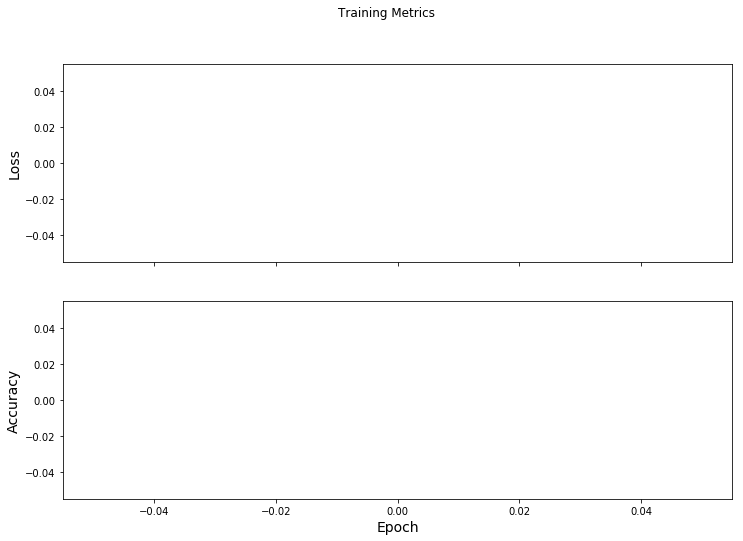

In [13]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)

plt.show()